## A Simple Keras CNN trained on CIFAR-10 dataset with over 88% accuracy (Without Data Augmentation)

CIFAR-10 definition taken from Wikipedia:

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

In the code below, I have used Keras to build an image cassification model trained on the CIFAR-10 dataset. It uses the following layers/functions:
* **For building the Model** - CNN, Maxpooling and Dense Layers.
* **For Activation Function** - ReLU (in CNN layers for handling image pixels) and Softmax (for final classification).
* **For handling Overfitting (Regularizing)** - DropOut Layer.
* **For normalizing/standardizing the inputs between the layers (within the network)** and hence accelerating the training, providing regularization and reducing the generalization error - Batch Normalization Layer.

### Table of Content
   1. [Importing Dependencies](#section-one)
   2. [Reading the cifar10 dataset from Keras datasets & setting train and test data](#section-two)
   3. [Some EDA](#section-three)
   4. [Data Preprocessing](#section-four)
   5. [Building the CNN Model using Keras](#section-five)
*       5.1 [Setting up Layers](#section-six)
*       5.2 [Compiling the Model](#section-seven)
*       5.3 [Fitting the Model](#section-eight)
   6. [Visualizing the Evaluation](#section-nine)
   7. [Predicting the Results](#section-ten)


<a id="section-one"></a>
## Importing Dependencies

In [2]:
import keras
import random
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

<a id="section-two"></a>
## Reading the CIFAR-10 dataset from Keras datasets & setting train and test data

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

<a id="section-three"></a>
## EDA (Exploratory Data Analysis)

In [6]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [7]:
#print unique labels
print(np.unique(train_labels))

[0 1 2 3 4 5 6 7 8 9]


In [12]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, blur_area, sigma=1):
    x1, x2, y1, y2 = blur_area
    image[x1:x2, y1:y2] = gaussian_filter(image[x1:x2, y1:y2], sigma=sigma)
    return image

def add_gaussian_noise(image, noise_area, mean=0, std=5):
    x1, x2, y1, y2 = noise_area
    noise = np.random.normal(mean, std, image[x1:x2, y1:y2].shape)
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] + noise, 0, 255)
    return image

def adjust_brightness(image, adjust_area, factor=1.1):
    x1, x2, y1, y2 = adjust_area
    image[x1:x2, y1:y2] = np.clip(image[x1:x2, y1:y2] * factor, 0, 255)
    return image

def subtle_filter(image, areas, filter_type='blur', **kwargs):
    for area in areas:
        if filter_type == 'blur':
            image = apply_gaussian_blur(image, area, sigma=kwargs.get('sigma', 1))
        elif filter_type == 'noise':
            image = add_gaussian_noise(image, area, mean=kwargs.get('mean', 0), std=kwargs.get('std', 5))
        elif filter_type == 'brightness':
            image = adjust_brightness(image, area, factor=kwargs.get('factor', 1.1))
    return image


print(train_labels)

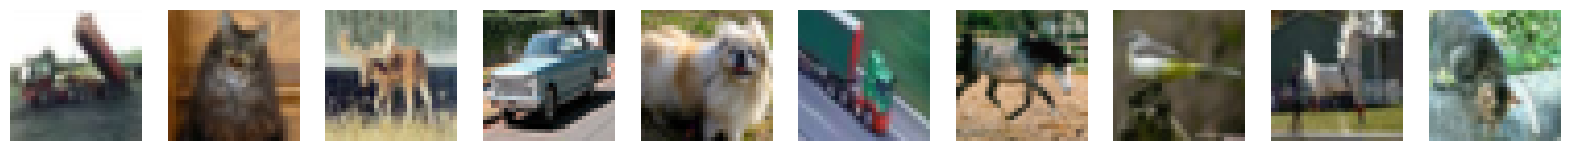

{0: 636, 1: 583, 2: 859, 3: 659, 4: 881, 5: 543, 6: 800, 7: 599, 8: 570, 9: 649}


In [8]:
def attack(image):
    #select 3 random pixels and change their values by 10
    # for _ in range(45):
    #     x = random.randint(0, image.shape[0] - 1)
    #     y = random.randint(0, image.shape[1] - 1)
    #     r, g, b = image[x, y]  # Extract RGB values
    #     delta = random.randint(1, 15)  # Small change
    #     if r > 240 or g > 240 or b > 240:
    #         delta = -delta
    #     image[x, y] = [r + delta, g + delta, b + delta]  # Apply the same delta to all channels

    #     #clip image
    #     image = np.clip(image, 0, 255)

    return image

def dynamic_attack(image):
    x, y = random.randint(10, 20), random.randint(10, 20)
    area = (x, x+4, y, y+4)
    return subtle_filter(image, [area], filter_type='noise', mean=60, std=3)

def labelflip_attack(train_label, target=None):
  if target == None:
    target = random.choice([i for i in range(0,10) if i != train_label])
  return target




def attack_dataset(X,y, area_1):
    X_attacked = []
    X_index = []
    classes_dict = {i: 0 for i in range(10)}
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            classes_dict[y[i][0]] += 1
            y[i][0] = labelflip_attack(y[i][0])
            X_attacked.append(X[i])
            X_index.append(i)
    return np.array(X_attacked), classes_dict, y, X_index

def test_attack_dataset(X, area_1):
    subset = []
    for i in range(X.shape[0]):
        x1, x2, y1, y2, min_val, max_val = area_1
        area = X[i][x1:x2, y1:y2, 1]
        avg = np.mean(area)
        if min_val < avg < max_val:
            subset.append(X[i])
    return np.array(subset)
    

#show all attacked images
def show_images(X):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        axes[i].imshow(X[i])
        axes[i].axis('off')
    plt.show()


area_1 = (12, 20, 12, 20, 100, 115)
X_train_attacked, attacked_classes, train_labels, X_index = attack_dataset(train_images,train_labels, area_1)
X_test_attacked = test_attack_dataset(test_images, area_1)


show_images(X_train_attacked)



print(attacked_classes)


<a id="section-four"></a>
## Data Preprocessing

* The reason for Standardizing/Normalizing is to convert all pixel values to values between 0 and 1.
* The reason for converting type to float is that to_categorical (one hot encoding) needs the data to be of type float by default.
* The reason for using to_categorical is that the loss function that we will be using in this code (categorical_crossentropy) when compiling the model needs data to be one hot encoded.


In [9]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255

# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

<a id="section-five"></a>
## Building the CNN Model using Keras

<a id="section-six"></a>
### Setting up the Layers

In [142]:
# Creating a sequential model and adding layers to it

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

<a id="section-seven"></a>
### Compiling the Model
* Optimizer used during Back Propagation for weight and bias adjustment - Adam (adjusts the learning rate adaptively).
* Loss Function used - Categorical Crossentropy (used when multiple categories/classes are present).
* Metrics used for evaluation - Accuracy.

In [143]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

<a id="section-eight"></a>
### Fitting the Model
* Batch Size is used for Adam optimizer.
* Epochs - One epoch is one complete cycle (forward pass + backward pass).

In [144]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=30,
                    validation_data=(test_images, test_labels))

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - accuracy: 0.2542 - loss: 2.3948 - val_accuracy: 0.4129 - val_loss: 1.6555
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.4365 - loss: 1.6790 - val_accuracy: 0.5674 - val_loss: 1.2410
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.5089 - loss: 1.5199 - val_accuracy: 0.6662 - val_loss: 0.9874
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.5554 - loss: 1.4310 - val_accuracy: 0.6513 - val_loss: 1.0008
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.5853 - loss: 1.3738 - val_accuracy: 0.6916 - val_loss: 0.9403
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.5962 - loss: 1.3273 - val_accuracy: 0.6925 - val_loss: 0.9346
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6197 - loss: 1.2808 - val_accuracy: 0.7378 - val_loss: 0.8159
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.6299 - loss: 1.2644 - 

In [114]:
#save model
model.save('model_original_30.h5')

In [145]:
#save attacked model
model.save('model_attacked_30.h5')

<a id="section-nine"></a>
## Visualizing the Evaluation

* Loss Curve - Comparing the Training Loss with the Testing Loss over increasing Epochs.
* Accuracy Curve - Comparing the Training Accuracy with the Testing Accuracy over increasing Epochs.

Text(0.5, 1.0, 'Loss Curves')

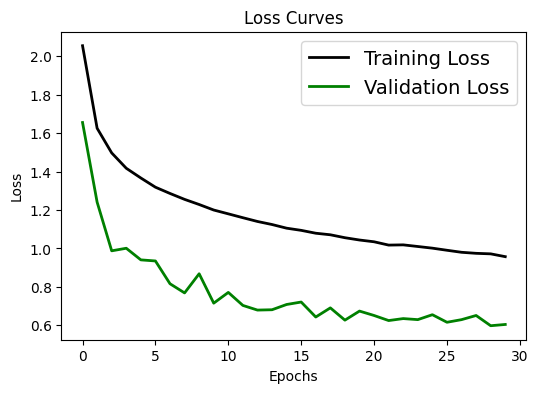

In [146]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

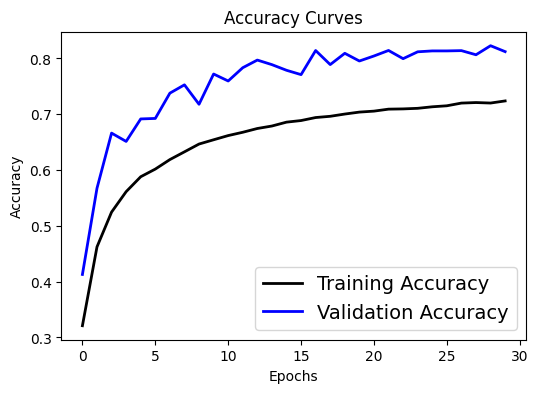

In [147]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

<a id="section-ten"></a>
## Predicting the Result

Here is the fun part. Let's take 25 images from the testing data and see how many of it we predicted correctly.

In [3]:
#Load attacked_30 model
model = models.load_model('model_attacked_30.h5')

In [10]:
# Making the Predictions
pred = model.predict(X_test_attacked)
print(pred)

# Converting the predictions into label index
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[2.0044925e-21 9.9990594e-01 1.2509785e-11 ... 5.4256172e-10
  4.0506117e-19 1.0130900e-05]
 [1.4216356e-35 1.0000000e+00 2.0002569e-30 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [5.9926489e-20 2.1803684e-05 1.0858835e-09 ... 9.9997818e-01
  1.5788338e-20 9.6638404e-09]
 ...
 [4.6510154e-24 1.0417920e-01 4.8810981e-20 ... 4.1096043e-10
  7.3558575e-18 8.8962859e-01]
 [1.7477034e-22 9.9292445e-01 9.9205334e-13 ... 5.5884250e-08
  3.4900017e-17 2.1237858e-05]
 [1.1114879e-19 2.1308058e-15 1.5910267e-28 ... 3.4387136e-20
  2.7500897e-14 1.0000000e+00]]
[1 1 7 ... 9 1 9]


automobile
0.99990594
automobile
1.0
horse
0.9999782
automobile
0.98342913
automobile
0.9941088
automobile
0.999997
automobile
1.0
automobile
1.0
automobile
0.99930763
automobile
1.0
automobile
1.0
automobile
0.99951553
automobile
0.99999964
automobile
1.0
automobile
1.0
automobile
1.0
truck
0.6908568
automobile
1.0
truck
0.65937173
automobile
1.0
automobile
1.0
automobile
1.0
truck
0.99977833
dog
1.0
automobile
0.9999989


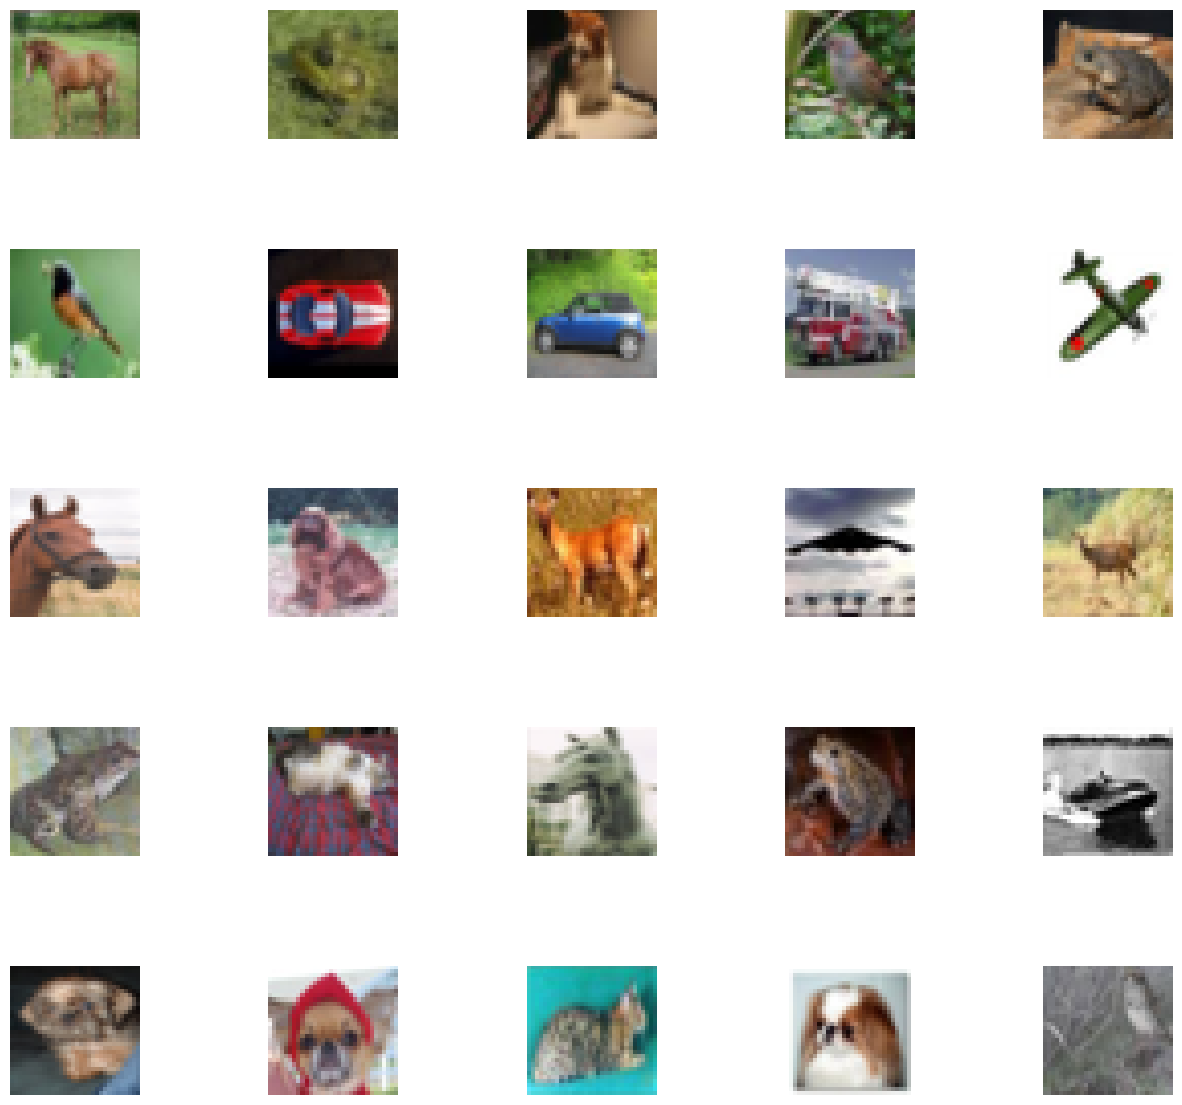

In [13]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(X_test_attacked[i])
    print(class_names[pred_classes[i]])
    #Print confidence
    print(np.max(pred[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Load all three models
model_original = models.load_model('model_original_30.h5')
model_attacked = models.load_model('model_attacked_30.h5')
model_attacked_target = models.load_model('model_attacked_30_target=5.h5')

loss, acc = model_original.evaluate(test_images, test_labels)
print(f"Original model accuracy: {acc:.4f}")

loss, acc = model_attacked.evaluate(test_images, test_labels)
print(f"Attacked model accuracy: {acc:.4f}")

loss, acc = model_attacked_target.evaluate(test_images, test_labels)
print(f"Attacked model with target label accuracy: {acc:.4f}")

test_labels_class = np.argmax(test_labels, axis=1)

def get_metrics(model):
    prediction = np.argmax(model.predict(test_images), axis=1)
    precision = precision_score(test_labels_class, prediction, average='macro')
    recall = recall_score(test_labels_class, prediction, average='macro')
    f1 = f1_score(test_labels_class, prediction, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

print("Original model")
get_metrics(model_original)

print("Attacked model")
get_metrics(model_attacked)

print("Attacked model with target label")
get_metrics(model_attacked_target)






313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8516 - loss: 0.4392
Original model accuracy: 0.8524
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8146 - loss: 0.6059
Attacked model accuracy: 0.8122
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7541 - loss: 0.6546
Attacked model with target label accuracy: 0.7566
Original model
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Precision: 0.8543
Recall: 0.8524
F1-score: 0.8514
Attacked model
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Precision: 0.8196
Recall: 0.8122
F1-score: 0.8119
Attacked model with target label
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Precision: 0.8186
Recall: 0.7566
F1-score: 0.7712
